In [2]:
import pandas as pd
from io import StringIO, BytesIO
from itertools import chain

from datasets import load_dataset, Dataset
import evaluate
from transformers import AutoModelForMaskedLM, AutoTokenizer, DataCollatorForLanguageModeling

In [ ]:
import boto3

SAGEMAKER_ROLE = 'arn:aws:iam::483285841698:role/service-role/AmazonSageMaker-ExecutionRole-20200612T174829'
BUCKET = "cci-data-science-devaccount"
PROFILE_NAME = "dsa"
REGION = "us-east-1"

boto_session = boto3.Session(
    region_name=REGION,
    profile_name=PROFILE_NAME,
)

s3_client = boto_session.client(
    service_name="s3",
)

# Prepare dataset

In [70]:
# load datasets
ds = load_dataset("bigcode/the-stack", data_dir="data/yaml", streaming=True, split="train")

train_list, test_list = [], []
counter = 0

for sample in iter(ds):
    if '.circleci/config.yml' in sample['max_stars_repo_path']:
        if counter <= 10000:
            train_list.append(sample['content'])
        elif counter <= 20000:
            test_list.append(sample['content'])
        else:
            break
        counter += 1

In [71]:
train_list[:5]

['cache_version_keys: &cache_version_keys\n  CACHE_VERSION_OF_PROJECT_DEPS: v2\n  CACHE_VERSION_OF_DANGER_CACHE: v1\n\ncache_keys:\n  gradle_cache:\n    primary: &primary_key_of_gradle_cache gradle-cache-{{ checksum "~/CACHE_VERSION_OF_PROJECT_DEPS" }}}-{{ checksum "~/project_hash.txt" }}\n    keys: &all_keys_of_gradle_cache\n      - *primary_key_of_gradle_cache\n      - gradle-cache-{{ checksum "~/CACHE_VERSION_OF_PROJECT_DEPS" }}-\n  danger_cache:\n    primary: &primary_key_of_danger_cache danger-cache-{{ checksum "~/CACHE_VERSION_OF_DANGER_CACHE" }}-{{ checksum "~/danger_cache" }}\n    keys: &all_keys_of_danger_cache\n      - *primary_key_of_danger_cache\n      - danger-cache-{{ checksum "~/CACHE_VERSION_OF_DANGER_CACHE" }}-\n\ndocker_env:\n  android_defaults: &android_defaults\n    working_directory: ~/conference-app-2019\n    docker:\n      - image: circleci/android:api-28-alpha\n    environment:\n      <<: *cache_version_keys\n      JAVA_OPTS: "-Xmx1024m"\n      GRADLE_OPTS: \'-D

In [72]:
test_list[:5]

['shared_configs:\n  simple_job_steps: &simple_job_steps\n    - checkout\n    - run:\n        name: Run tests\n        command: |\n          make deps test\n\n\n# Use the latest 2.1 version of CircleCI pipeline process engine. See: https://circleci.com/docs/2.0/configuration-reference\nversion: 2.1\njobs:\n  build-1-12:\n    working_directory: ~/repo\n    docker:\n      - image: circleci/golang:1.12\n    environment:\n      GO111MODULE: "on"\n    steps: *simple_job_steps\n\n  build-1-13:\n    working_directory: ~/repo\n    docker:\n      - image: circleci/golang:1.13\n    steps: *simple_job_steps\n\n  build-1-14:\n    working_directory: ~/repo\n    docker:\n      - image: circleci/golang:1.14\n    steps: *simple_job_steps\n\n  build-1-15:\n    working_directory: ~/repo\n    docker:\n      - image: circleci/golang:1.15\n    environment:\n      GO111MODULE: "on"\n    steps:\n      - checkout\n      - restore_cache:\n          keys:\n            - go-mod-v4-{{ checksum "go.sum" }}\n      

In [83]:
df_train = pd.DataFrame()
df_train['content'] = train_list

df_test = pd.DataFrame()
df_test['content'] = test_list

In [85]:
csv_buffer = StringIO()
df_train.to_csv(csv_buffer, index=False)
s3_client.put_object(
    Bucket=BUCKET,
    Body=csv_buffer.getvalue(),
    Key=f'hackweek-2023/train/train.csv'
)

csv_buffer = StringIO()
df_test.to_csv(csv_buffer, index=False)
s3_client.put_object(
    Bucket=BUCKET,
    Body=csv_buffer.getvalue(),
    Key=f'hackweek-2023/test/test.csv'
)

{'ResponseMetadata': {'RequestId': 'N2211F02SA7XGERK',
  'HostId': 'zHVavKRhzctY1HgohdE8QjTN2kJHGE/0aD2bxLHG7yTMbTxjGZNqtk0Xm2UGBf0upoc8hhaP86g=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'zHVavKRhzctY1HgohdE8QjTN2kJHGE/0aD2bxLHG7yTMbTxjGZNqtk0Xm2UGBf0upoc8hhaP86g=',
   'x-amz-request-id': 'N2211F02SA7XGERK',
   'date': 'Tue, 13 Jun 2023 20:46:34 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"3b0d13b22a235f38a1953bdd644ab50f"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"3b0d13b22a235f38a1953bdd644ab50f"',
 'ServerSideEncryption': 'AES256'}

In [4]:
obj = s3_client.get_object(
    Bucket=BUCKET,
    Key=f'hackweek-2023/train/train.csv'
)
df_train_from_s3 = pd.read_csv(BytesIO(obj['Body'].read()))

obj = s3_client.get_object(
    Bucket=BUCKET,
    Key=f'hackweek-2023/test/test.csv'
)
df_test_from_s3 = pd.read_csv(BytesIO(obj['Body'].read()))

In [6]:
df_train_from_s3

,content
0,cache_version_keys: &cache_version_keys\n CAC...
1,version: 2.1\n\norbs:\n rn: react-native-comm...
2,version: 2.1\njobs:\n python_steps:\n dock...
3,# Javascript Node CircleCI 2.0 configuration f...
4,version: 2.1\n\ncommands:\n tests:\n ...
...,...
9996,# CircleCI Pre-Built Docker Images\n# - https:...
9997,version: 2\n\njobs:\n deploy:\n docker:\n ...
9998,jobs:\n test:\n docker:\n - image: no...
9999,version: 2.1\njobs:\n build:\n docker:\n ...


In [7]:
df_test_from_s3

,content
0,shared_configs:\n simple_job_steps: &simple_j...
1,\nversion: 2.1\n\ncommands:\n greeting:\n ...
2,version: 2.1\n\ncommands:\n docker_hub_login:...
3,orbs: # declare what orbs we are going to use\...
4,version: 2.1\norbs:\n node: circleci/node@4.1...
...,...
9995,"version: ""2.1""\ncontext: pypi\nworkflows:\n b..."
9996,version: 2.1\n# This CircleCI orb doesn't seem...
9997,version: 2\nbuild:\n machine:\n java: orac...
9998,---\ndefaults:\n defaults: &defaults\n wor...


In [8]:
train_dataset = Dataset.from_dict({"content": df_train_from_s3.values.tolist()})

train_dataset

Dataset({
    features: ['content'],
    num_rows: 10001
})

In [9]:
list(train_dataset.features)

['content']

# Finetune base model

In [1]:
import boto3
import sagemaker

SAGEMAKER_ROLE = 'arn:aws:iam::483285841698:role/service-role/AmazonSageMaker-ExecutionRole-20200612T174829'
BUCKET = "cci-data-science-devaccount"
PROFILE_NAME = "dsa"
REGION = "us-east-1"

boto_session = boto3.Session(
    region_name=REGION,
    profile_name=PROFILE_NAME,
)

sagemaker_client = boto_session.client(
    service_name="sagemaker"
)

sagemaker_runtime_client = boto_session.client(
    service_name="sagemaker-runtime",
)

s3_client = boto_session.client(
    service_name="s3",
)

sagemaker_session = sagemaker.Session(
    boto_session = boto_session,
    sagemaker_client = sagemaker_client,
    sagemaker_runtime_client = sagemaker_runtime_client,
    default_bucket = BUCKET
)

In [2]:
from sagemaker.huggingface import HuggingFace

hyperparameters = {
	'model_name':'huggingface/CodeBERTa-small-v1',
	# 'max_samples':10
	# add your remaining hyperparameters
	# more info here https://github.com/huggingface/transformers/tree/v4.26.0/examples/pytorch/language-modeling
}

# creates Hugging Face estimator
huggingface_estimator = HuggingFace(
	entry_point='train.py',
	source_dir='./scripts',
	instance_type='ml.p3.2xlarge',
 	# instance_type='ml.g4dn.2xlarge',
	instance_count=1,
	role=SAGEMAKER_ROLE,
	sagemaker_session=sagemaker_session,
	transformers_version='4.26',
	pytorch_version='1.13',
	py_version='py39',
	hyperparameters = hyperparameters
)

training_input_path = 's3://cci-data-science-devaccount/hackweek-2023/train'
test_input_path = 's3://cci-data-science-devaccount/hackweek-2023/test'

In [3]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-pytorch-training-2023-06-15-01-44-07-575


2023-06-15 01:44:09 Starting - Starting the training job...
2023-06-15 01:44:34 Starting - Preparing the instances for training.........
2023-06-15 01:45:48 Downloading - Downloading input data...
2023-06-15 01:46:13 Training - Downloading the training image...............
2023-06-15 01:48:54 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-15 01:49:12,680 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-15 01:49:12,699 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-06-15 01:49:12,711 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-06-15 01:49:12,714 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-06-15 01:49:12,974 sagemaker-training-toolkit INFO     Installing dependencies 

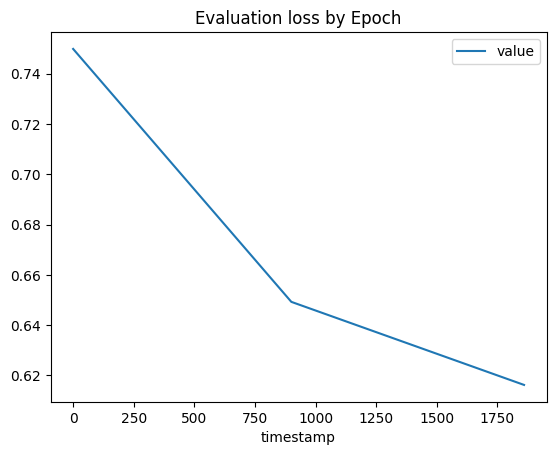

In [ ]:
from sagemaker import TrainingJobAnalytics
import matplotlib.pyplot as plt

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(
    sagemaker_session=sagemaker_session,
    # training_job_name=huggingface_estimator.latest_training_job.name,
    training_job_name='huggingface-pytorch-training-2023-06-16-12-44-28-921',
).dataframe()

df.plot(
    y='value',
    x='timestamp',
    kind='line',
    title='Evaluation loss by Epoch'
);

# Deploy finetuned model to endpoint

In [2]:
from sagemaker.huggingface import HuggingFaceModel

env = {'HF_TASK': 'fill-mask'}

huggingface_model = HuggingFaceModel(
   model_data="s3://cci-data-science-devaccount/huggingface-pytorch-training-2023-06-15-01-44-07-575/output/model.tar.gz",
   role=SAGEMAKER_ROLE,
   env=env,
   sagemaker_session=sagemaker_session,
   transformers_version="4.26",
   pytorch_version="1.13",
   py_version='py39',
)

finetuned_predictor = huggingface_model.deploy(1, "ml.g4dn.xlarge")

---------!

# Deploy base model to endpoint

In [19]:
from sagemaker.huggingface import HuggingFaceModel

# Hub Model configuration. https://huggingface.co/models
hub = {
  'HF_MODEL_ID':'huggingface/CodeBERTa-small-v1', # model_id from hf.co/models
  'HF_TASK':'fill-mask' # NLP task you want to use for predictions
}

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   env=hub,
   sagemaker_session=sagemaker_session,
   role=SAGEMAKER_ROLE, # iam role with permissions to create an Endpoint
   transformers_version="4.26", # transformers version used
   pytorch_version="1.13", # pytorch version used
   py_version="py39", # python version of the DLC
)

# deploy model to SageMaker Inference
base_predictor = huggingface_model.deploy(1, "ml.g4dn.xlarge")

--------!

# Endpoint input

In [36]:
fillmask_input = {"inputs": """
version: 2.1

# Define the jobs we want to run for this project

jobs:
  build:
    docker:
      - image: cimg/base:2023.03
    steps:
      - checkout
      - run: echo "this is the build job"
  test:
    docker:
      - image: cimg/base:2023.03
    steps:
      - checkout
      - run: echo "this is the test job"

# Orchestrate our job run sequence
workflows:
  build_and_test:
    jobs:
      - build
      - test  
"""}

# Predict using base model

In [27]:
from sagemaker.huggingface import HuggingFacePredictor

base_predictor = HuggingFacePredictor(
    endpoint_name = "huggingface-pytorch-inference-2023-06-15-13-50-19-012",
    sagemaker_session=sagemaker_session,
)

In [37]:
base_predictor.predict(fillmask_input)

[{'score': 0.6635156869888306,
  'token': 8377,
  'token_str': ' docker',
  'sequence': '\nversion: 2.1\n\n# Define the jobs we want to run for this project\n\njobs:\n  build:\n    docker:\n      - image: cimg/base:2023.03\n    steps:\n      - checkout\n      - run: echo "this is the build job"\n  test:\n    docker:\n      - image: cimg/base:2023.03\n    steps:\n      - checkout\n      - run: echo "this is the test job"\n\n# Orchestrate our job run sequence\nworkflows:\n  build_and_test: docker:\n      - build\n      - test  \n'},
 {'score': 0.03197328373789787,
  'token': 1586,
  'token_str': ' run',
  'sequence': '\nversion: 2.1\n\n# Define the jobs we want to run for this project\n\njobs:\n  build:\n    docker:\n      - image: cimg/base:2023.03\n    steps:\n      - checkout\n      - run: echo "this is the build job"\n  test:\n    docker:\n      - image: cimg/base:2023.03\n    steps:\n      - checkout\n      - run: echo "this is the test job"\n\n# Orchestrate our job run sequence\nwo

# Predict using finetuned model

In [24]:
from sagemaker.huggingface import HuggingFacePredictor

finetuned_predictor = HuggingFacePredictor(
    endpoint_name = "huggingface-pytorch-inference-2023-06-15-12-37-17-396",
    sagemaker_session=sagemaker_session,
)

In [38]:
finetuned_predictor.predict(fillmask_input)

[{'score': 0.5346051454544067,
  'token': 8768,
  'token_str': ' jobs',
  'sequence': ' \nversion: 2.1\n\n# Define the jobs we want to run for this project\n\njobs:\n  build:\n    docker:\n      - image: cimg/base:2023.03\n    steps:\n      - checkout\n      - run: echo "this is the build job"\n  test:\n    docker:\n      - image: cimg/base:2023.03\n    steps:\n      - checkout\n      - run: echo "this is the test job"\n\n# Orchestrate our job run sequence\nworkflows:\n  build_and_test: jobs :\n      - build\n      - test  \n'},
 {'score': 0.11977247893810272,
  'token': 225,
  'token_str': ' ',
  'sequence': ' \nversion: 2.1\n\n# Define the jobs we want to run for this project\n\njobs:\n  build:\n    docker:\n      - image: cimg/base:2023.03\n    steps:\n      - checkout\n      - run: echo "this is the build job"\n  test:\n    docker:\n      - image: cimg/base:2023.03\n    steps:\n      - checkout\n      - run: echo "this is the test job"\n\n# Orchestrate our job run sequence\nworkflo

# Conclusions

Finetuned on 10K public configs, which took 1 hour on ml.p3.2xlarge.

Compare:
* 190M unique config hashes total available in our data
* 120M unique config hashes from paying customers

Potential future directions:
* Base model is pretrained on go, java, javascript, php, python, ruby. Better to use base model that is pretrained on yaml and shell scripts.
* Graduate from fill-mask to other NLP tasks, such as text generation.
* Finetune on larger and more curated dataset.
* Finetune large model, then distill to smaller one for faster inference.
    * For context, codeBERTa-small has 84M parameters, whereas Vicuna has 13B parameters and GPT-3.5 has 175B parameters

In [4]:
import gzip

In [10]:
s3 = boto_session.resource('s3')
s3.meta.client.download_file(
    Bucket=BUCKET,
    Key='huggingface-pytorch-training-2023-06-15-01-44-07-575/output/output.tar.gz',
    Filename='output.tar.gz'
)

In [13]:
metric_definitions=[
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    ]

In [14]:
from sagemaker.huggingface import HuggingFace

hyperparameters = {
	'model_name':'huggingface/CodeBERTa-small-v1',
	# 'max_samples':10
	# add your remaining hyperparameters
	# more info here https://github.com/huggingface/transformers/tree/v4.26.0/examples/pytorch/language-modeling
}

# creates Hugging Face estimator
huggingface_estimator = HuggingFace(
	entry_point='train.py',
	source_dir='./scripts',
	instance_type='ml.p3.2xlarge',
 	# instance_type='ml.g4dn.2xlarge',
	instance_count=1,
	role=SAGEMAKER_ROLE,
	sagemaker_session=sagemaker_session,
	transformers_version='4.26',
	pytorch_version='1.13',
	py_version='py39',
	hyperparameters = hyperparameters,
 	metric_definitions=metric_definitions,
)

training_input_path = 's3://cci-data-science-devaccount/hackweek-2023/train'
test_input_path = 's3://cci-data-science-devaccount/hackweek-2023/test'

In [15]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-pytorch-training-2023-06-16-12-44-28-921


2023-06-16 12:44:30 Starting - Starting the training job...
2023-06-16 12:44:55 Starting - Preparing the instances for training.........
2023-06-16 12:46:26 Downloading - Downloading input data
2023-06-16 12:46:26 Training - Downloading the training image.....................
2023-06-16 12:50:02 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-16 12:50:23,544 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-16 12:50:23,561 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-06-16 12:50:23,574 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-06-16 12:50:23,576 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-06-16 12:50:23,856 sagemaker-training-toolkit INFO     Installing dependen